# SEDIMENT MOBILITY ALONG THE KILMADE BURN

*This lesson has been written by Mikael Attal and Simon M. Mudd at the University of Edinburgh*

*Last update 26/10/2020*

In this exercise, we are going to use data to analyse sediment mobility in our studied catchment. The programme will take a csv file with the following data:
- Extracted from the DEM: x, y, elevation in m (lamm_fill), stream length in m (lamm_length), drainage area A in $m^2$ (lamm_flowacc).
- Measured in the field: width W (in m), slope S (in m/m) and median grain size D50 (in mm).

The last row in the list is the outlet row. 

In [1]:
#import modules
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#read data from file:
f = open("DataSediment.csv",'r')  # open file
lines = f.readlines()   # read in the data
n_lines = len(lines)   # get the number of lines (=number of data+1)

#initialise the arrays that will contain the data:
elev=[]; length=[]; area=[]; W=[]; S=[]; D50mm=[];
#place the values in the arrays:
for i in range(1, len(lines)):
    line = lines[i].strip().split(",")
    #print(line)
    elev.append(float(line[2]))
    length.append(float(line[3]))
    area.append(int(line[4]))
    W.append(float(line[5]))
    S.append(float(line[6]))
    D50mm.append(float(line[7]))

D50 = np.divide(D50mm, 1000) #Conversion of D50 from mm to m.


In [3]:
# We will try to load this file into a pandas dataframe
import pandas as pd
shear_df = pd.read_csv("DataSediment.csv")
print(shear_df)

           x         y  lamm_fill  lamm_length  lamm_flowac     W      S  D50
0   365502.5  661032.5   374.7373    3497.1120       157575   1.5  0.080  105
1   365682.5  661117.5   358.1249    3276.0470       374850   1.8  0.076  132
2   366042.5  661702.5   299.7072    2881.0000      1028100   3.4  0.075   52
3   366097.5  661887.5   287.2641    2320.0080      1994675   3.8  0.082   70
4   366077.5  661962.5   283.5799    2236.7240      2022075   6.1  0.062   61
5   366037.5  662187.5   270.0589    1982.7290      2125100   6.8  0.022   55
6   366272.5  662532.5   250.0295    1516.9580      3354350   7.5  0.025   68
7   366282.5  662662.5   244.8019    1378.6740      3401000   8.9  0.020   59
8   366377.5  662797.5   237.5375    1198.4660      3477025   8.4  0.020   92
9   366392.5  662887.5   233.9766    1098.1110      3558375  12.6  0.021   89
10  366457.5  662957.5   228.4461     989.4717      3603900  10.6  0.030   98
11  366497.5  663022.5   225.3323     894.9744      3633050   5.

We need to do a unit conversion to get the D50 in metres:

In [4]:
shear_df["D50_metres"] = np.divide(shear_df.D50, 1000)

## Here, set the discharge at the outlet that you want to consider (in $m^3/s$):

Based on the information in the csv file, we are going to calculate the equivalent discharge for all the "sampling points" in the csv file, assuming that discharge is proportional to drainage area. We are also going to calculate the equivalent rainfall that this discharge would correspond to, assuming that there is no storage or evapotranspiration: all the water joins the channel instantly (not a too bad approximation for small catchments).

In [5]:
Q_outlet = 4.6
PrecipitationEqSI=Q_outlet/area[len(area)-1] #Calculation of equivalent precipitation in m/s (SI units)
PrecipitationEq=PrecipitationEqSI*1000*3600 #Calculation of equivalent precipitation in mm/hr
print("The equivalent precipitation rate for a discharge of "+str(Q_outlet)+" m^3/s at the outlet is "+str(PrecipitationEq)+" mm/hr.")


shear_df["Q"] = np.multiply(shear_df.lamm_flowac,PrecipitationEqSI)
shear_df.head()

The equivalent precipitation rate for a discharge of 4.6 m^3/s at the outlet is 4.451882170292557 mm/hr.


,x,y,lamm_fill,lamm_length,lamm_flowac,W,S,D50,D50_metres,Q
0,365502.5,661032.5,374.7373,3497.112,157575,1.5,0.080,105,0.105,0.194863
1,365682.5,661117.5,358.1249,3276.047,374850,1.8,0.076,132,0.132,0.463552
2,366042.5,661702.5,299.7072,2881.000,1028100,3.4,0.075,52,0.052,1.271383
3,366097.5,661887.5,287.2641,2320.008,1994675,3.8,0.082,70,0.070,2.466683
4,366077.5,661962.5,283.5799,2236.724,2022075,6.1,0.062,61,0.061,2.500567


## Does this value seem realistic?

Ok, next step:

## Calculating the shear stress for each sample point:

Now, we are going to calculate the dimensionless shear stress corresponding to this discharge at each of our sample point, to determine if sediment transport is likely to happen. 
To do that, we first need to calculate the flow velocity, depth and hydraulic radius associated with this discharge. We need to use an iterative method, as shown in the handout.

In [6]:
#Set the Manning's coefficient:
n=0.03 #A value of 0.03 is typically used for mountain rivers with cobble to boulder sized sediment
D=[]; V=[]; R=[]; #Initializing the arrays for depth, velocity and hydraulic radius. 

Q = shear_df.Q
W = shear_df.W
S = shear_df.S



for i in range(0, len(Q)):
    #The iterative method uses first the assumption that R = D to calculate flow velocity. We call these values "test" as we will perform a test until we converge to the real values (which we will then store)
    V_test=pow(((pow(Q[i],2/3)*pow(W[i],-2/3)*pow(S[i],0.5))/n),0.6)
    D_test=Q[i]/(V_test*W[i])
    R_test=(W[i]*D_test)/(W[i]+2*D_test)
    
    #We are now running the iterative method: we now have a value for R, which we can use to calculate V again, and then D and R. We can then compare these values, and run the method until we converge to an acceptable value
    keepgoing = 1
    while keepgoing: #while the condition hasn't been fulfilled, run the code below again and again (loop)
        V_test=(pow(R_test,2/3)*pow(S[i],0.5))/n #Calculate V_test but this time using the hydraulic radius calculated above
        D_test=Q[i]/(V_test*W[i])
        R_test2=(W[i]*D_test)/(W[i]+2*D_test) #Define a new R_test2 that we will compare to R_test to see if the condition has been fullfilled
        
        Test_value=pow(pow(((R_test2-R_test)/R_test2),2),0.5) #Test value is the percent difference between R_test2 and R_test (squared, then square root to avoid negative values)
        #print(Test_value)
        
        if Test_value <= 0.0001: #if the difference between R_test and R_test2 is less than 0.01 %, then we have converged towards an acceptable value --> stop and store the data. Otherwise, keep going!
            keepgoing = 0 #stops the while loop
            V.append(V_test)
            D.append(D_test)
            R.append(R_test)
        else:
            R_test=R_test2 #If the condition hasn't been fulfilled, give R_test the new value of R_test2 and try again!

shear_df["V"] = V
shear_df["D"] = D
shear_df["R"] = R
 
shear_df.head() 

,x,y,lamm_fill,lamm_length,lamm_flowac,W,S,D50,D50_metres,Q,V,D,R
0,365502.5,661032.5,374.7373,3497.112,157575,1.5,0.080,105,0.105,0.194863,1.631531,0.079624,0.071988
1,365682.5,661117.5,358.1249,3276.047,374850,1.8,0.076,132,0.132,0.463552,2.089378,0.123256,0.108417
2,366042.5,661702.5,299.7072,2881.000,1028100,3.4,0.075,52,0.052,1.271383,2.457465,0.152163,0.139674
3,366097.5,661887.5,287.2641,2320.008,1994675,3.8,0.082,70,0.070,2.466683,3.124576,0.207749,0.187287
4,366077.5,661962.5,283.5799,2236.724,2022075,6.1,0.062,61,0.061,2.500567,2.439073,0.168068,0.159304


We now have all the information we need to calculate the shear stress (in Pascals) and the dimensionless shear stress (Shields stress).

In [7]:
shear_df["Tau"] = 1000*9.81*np.multiply(shear_df.R,shear_df.S)
shear_df["Tau_star"] = np.divide(shear_df.Tau,1650*9.81*shear_df.D50_metres)
shear_df["Tau_crit"] = np.full_like(shear_df["Tau"],0.045)

shear_df.head()

,x,y,lamm_fill,lamm_length,lamm_flowac,W,S,D50,D50_metres,Q,V,D,R,Tau,Tau_star,Tau_crit
0,365502.5,661032.5,374.7373,3497.112,157575,1.5,0.080,105,0.105,0.194863,1.631531,0.079624,0.071988,56.495816,0.033241,0.045
1,365682.5,661117.5,358.1249,3276.047,374850,1.8,0.076,132,0.132,0.463552,2.089378,0.123256,0.108417,80.831371,0.037831,0.045
2,366042.5,661702.5,299.7072,2881.000,1028100,3.4,0.075,52,0.052,1.271383,2.457465,0.152163,0.139674,102.765487,0.122093,0.045
3,366097.5,661887.5,287.2641,2320.008,1994675,3.8,0.082,70,0.070,2.466683,3.124576,0.207749,0.187287,150.657572,0.132966,0.045
4,366077.5,661962.5,283.5799,2236.724,2022075,6.1,0.062,61,0.061,2.500567,2.439073,0.168068,0.159304,96.891580,0.098130,0.045


## Ok, we've got all the information we need now! Let's plot the data!

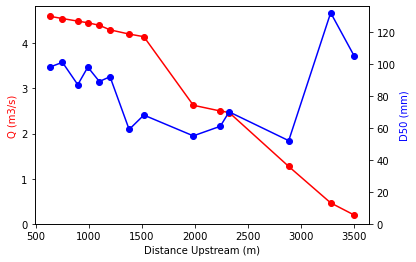

In [8]:
fig,ax = plt.subplots()
ax.plot(shear_df.lamm_length, shear_df.Q, color="red", marker="o")
ax.set_xlabel("Distance Upstream (m)")
ax.set_ylabel("Q (m3/s)",color="red")
plt.ylim(ymin=0)

ax2=ax.twinx()
ax2.plot(shear_df.lamm_length, shear_df.D50, color="blue",marker="o")
ax2.set_ylabel("D50 (mm)",color="blue")
plt.ylim(ymin=0)
plt.show()

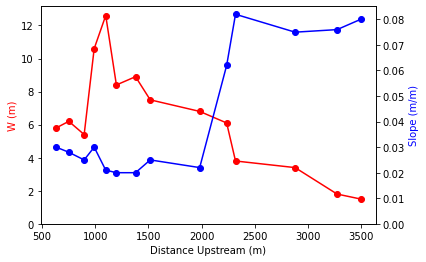

In [9]:
fig,ax = plt.subplots()
ax.plot(shear_df.lamm_length, shear_df.W, color="red", marker="o")
ax.set_xlabel("Distance Upstream (m)")
ax.set_ylabel("W (m)",color="red")
plt.ylim(ymin=0)

ax2=ax.twinx()
ax2.plot(shear_df.lamm_length, shear_df.S, color="blue",marker="o")
ax2.set_ylabel("Slope (m/m)",color="blue")

plt.ylim(ymin=0)
plt.show()

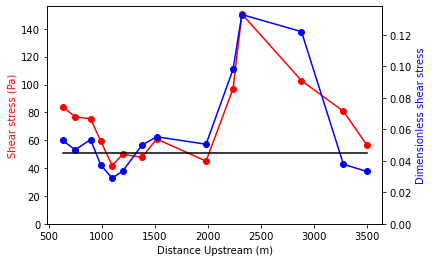

In [10]:
fig,ax = plt.subplots()
ax.plot(shear_df.lamm_length, shear_df.Tau, color="red", marker="o")
ax.set_xlabel("Distance Upstream (m)")
ax.set_ylabel("Shear stress (Pa)",color="red")
plt.ylim(ymin=0)

ax2=ax.twinx()
ax2.plot(shear_df.lamm_length, shear_df.Tau_star, color="blue",marker="o")
ax2.plot(shear_df.lamm_length, shear_df.Tau_crit, color="black")
ax2.set_ylabel("Dimensionless shear stress",color="blue")
plt.ylim(ymin=0)
plt.show()

Now print all this data to a csv file

In [11]:
shear_df.to_csv("Processed_sediment_data.csv")

If you want to see where the data is in space, you can convert to a geopandas object

In [12]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(
    shear_df, geometry=gpd.points_from_xy(shear_df.x, shear_df.y))
# Set the coordinate reference system as british national grid 
# YOU NEED A RECENT VERSION OF GEOPANDAS FOR THIS
#gdf = gdf.set_crs(epsg=27700)
gdf.head()

,x,y,lamm_fill,lamm_length,lamm_flowac,W,S,D50,D50_metres,Q,V,D,R,Tau,Tau_star,Tau_crit,geometry
0,365502.5,661032.5,374.7373,3497.112,157575,1.5,0.080,105,0.105,0.194863,1.631531,0.079624,0.071988,56.495816,0.033241,0.045,POINT (365502.500 661032.500)
1,365682.5,661117.5,358.1249,3276.047,374850,1.8,0.076,132,0.132,0.463552,2.089378,0.123256,0.108417,80.831371,0.037831,0.045,POINT (365682.500 661117.500)
2,366042.5,661702.5,299.7072,2881.000,1028100,3.4,0.075,52,0.052,1.271383,2.457465,0.152163,0.139674,102.765487,0.122093,0.045,POINT (366042.500 661702.500)
3,366097.5,661887.5,287.2641,2320.008,1994675,3.8,0.082,70,0.070,2.466683,3.124576,0.207749,0.187287,150.657572,0.132966,0.045,POINT (366097.500 661887.500)
4,366077.5,661962.5,283.5799,2236.724,2022075,6.1,0.062,61,0.061,2.500567,2.439073,0.168068,0.159304,96.891580,0.098130,0.045,POINT (366077.500 661962.500)


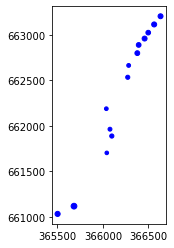

In [13]:
import matplotlib.cm as cm
gdf.plot(marker='.', color="b", markersize=gdf.D50);